Heart attack analysis and prediction

Dataset link
https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

In [2]:
#!pip install --user --upgrade catboost
#!pip install ipywidgets==7.7.2
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures, Normalizer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, accuracy_score, f1_score, precision_score, recall_score 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Data preprocessing and preparation

In [4]:
df = pd.read_csv('heart.csv')

In [5]:
#Renaming the columns of the df for better understanding the names of the features
col_name_dict = {
    'cp': 'chest pain type',
    'trtbps': 'resting blood pressure',
    'chol': 'cholesterol',
    'fbs': 'fasting bld sugar > 120',
    'restecg': 'rest cardiogr. res',
    'thalachh': 'max heart rate',
    'exng': 'exercise induced angina',
    'slp': 'slope',
    'caa': 'N of major vessels',
    'thall': 'thal rate',
    'output': 'target'
}

df = df.rename(columns=col_name_dict)

df.head()

,age,sex,chest pain type,resting blood pressure,cholesterol,fasting bld sugar > 120,rest cardiogr. res,max heart rate,exercise induced angina,oldpeak,slope,N of major vessels,thal rate,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Pandas profiling for inspecting features more deeply and understanding the data better

In [6]:
#from pandas_profiling import ProfileReport
#from summarytools import dfSummary

#profile = ProfileReport(df)
#profile.to_file("profile_output.html")

#dfSummary(df)

In [7]:
df.isnull().sum()
#no null elements

age                        0
sex                        0
chest pain type            0
resting blood pressure     0
cholesterol                0
fasting bld sugar > 120    0
rest cardiogr. res         0
max heart rate             0
exercise induced angina    0
oldpeak                    0
slope                      0
N of major vessels         0
thal rate                  0
target                     0
dtype: int64

In [8]:
print('Before: ', df.shape)
df = df.drop_duplicates(ignore_index=True)
print('After: ', df.shape)

Before:  (303, 14)
After:  (302, 14)


In [9]:
#Number of unique examples per feature
df.nunique(axis=0)

age                         41
sex                          2
chest pain type              4
resting blood pressure      49
cholesterol                152
fasting bld sugar > 120      2
rest cardiogr. res           3
max heart rate              91
exercise induced angina      2
oldpeak                     40
slope                        3
N of major vessels           5
thal rate                    4
target                       2
dtype: int64

In [10]:
df['N of major vessels'].value_counts()
#N of major vessels=4 from data description-> it is null and since 0 is dominant,
#we just change the value to 0 because there are only 5 such rows 
df[df['N of major vessels'] == 4] = 0

In [11]:
#Viewing various characterstics about our data
df.describe()

,age,sex,chest pain type,resting blood pressure,cholesterol,fasting bld sugar > 120,rest cardiogr. res,max heart rate,exercise induced angina,oldpeak,slope,N of major vessels,thal rate,target
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,53.788079,0.668874,0.947020,129.837748,243.635762,0.145695,0.516556,147.486755,0.324503,1.041391,1.377483,0.665563,2.281457,0.533113
std,10.928404,0.471399,1.032933,23.131938,58.792103,0.353386,0.526435,28.533913,0.468966,1.162699,0.633943,0.935142,0.664916,0.499730
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,210.250000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,165.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


In [12]:
#Getting Feature matrix and Target vector
X = df.drop(columns=['target'], axis=1)
y = df['target']

In [13]:
#One Hot Encoding
cols = ['chest pain type', 'slope', 'thal rate', 'rest cardiogr. res'] #
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_features = encoder.fit_transform(X[cols]).toarray()
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cols))

X_old = X #We keep the old version of X for training models like CatBoost, LightGBM who can handle cat. features by themselves

X = X.drop(columns=cols)
X = pd.concat([encoded_df, X], axis=1)

#Columns renamed according to data description in Kaggle
renamed_columns = {
    'chest pain type_0': 'non-anginal pain',
    'chest pain type_1': 'typical angina',
    'chest pain type_2': 'atypical angina',
    'chest pain type_3': 'asymptomatic',
    'slope_0': 'downsloping', 
    'slope_1': 'flat',
    'slope_2': 'upsloping',
    'rest cardiogr. res_0': 'hypertropy',
    'rest cardiogr. res_1': 'normal',
    'rest cardiogr. res_2': 'ST-T abnormality',
    'thal rate_0': 'fixed',
    'thal rate_1': 'normal',
    'thal rate_2': 'reversable defect' 
}

X = X.rename(columns=renamed_columns)

# Feature distributions and outlier detection

### Correlation Matrix

<AxesSubplot: >

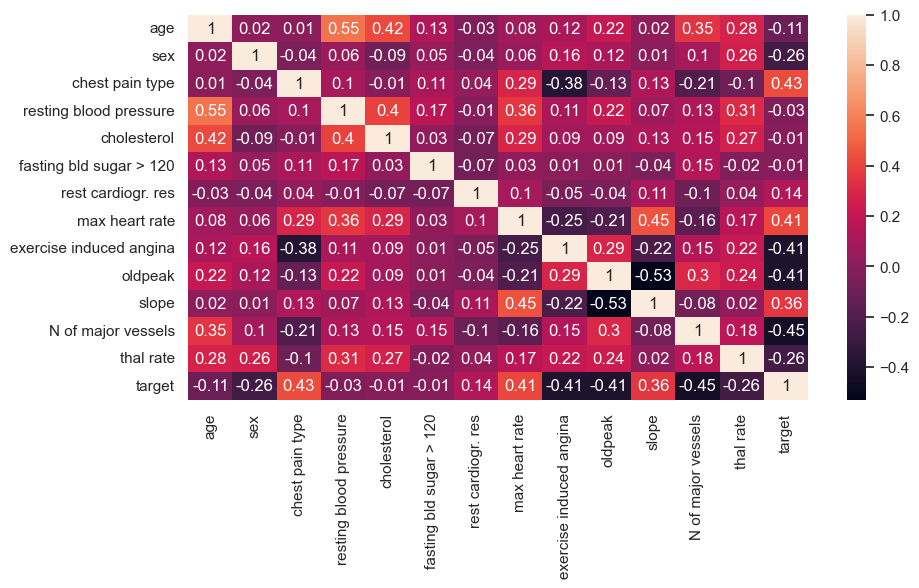

In [14]:
#Calculating correlation and making a heatmap
figure = plt.figure(figsize=(10, 5))
corr_df = df.corr()
corr_df = np.round(corr_df, 2)
sns.heatmap(corr_df, annot=True)
#There are no obvious correlations between features, with biggest correlation = 0.55

### Boxplots for outlier detection

<AxesSubplot: xlabel='age'>

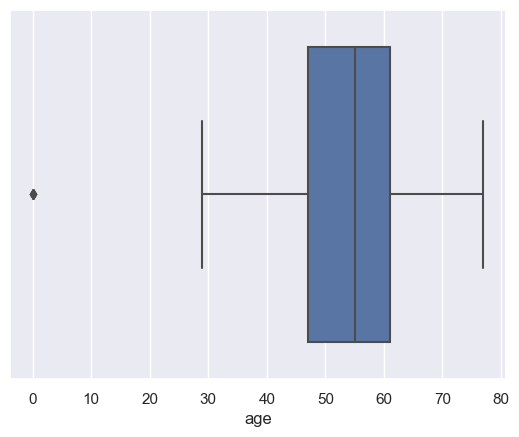

In [15]:
sns.boxplot(x=X['age'])

In [16]:
#Dropping 4 obvious mistakes (outliers) in our dataset
rows_to_drop = X[X['age'] == 0].index

X = X.drop(rows_to_drop)
X_old = X_old.drop(rows_to_drop)
y = y.drop(rows_to_drop)

<AxesSubplot: xlabel='resting blood pressure'>

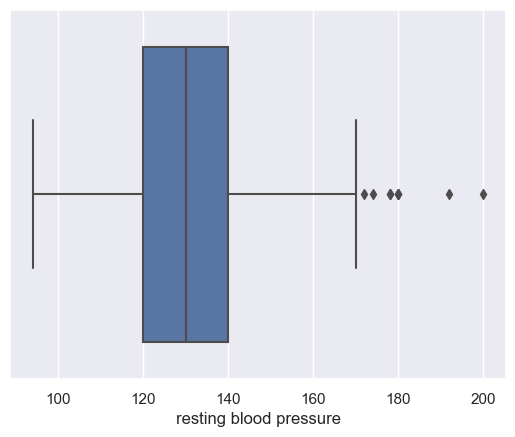

In [17]:
#Here we won't delete anything because resting blood pressure of 200 is possible, and can be valuable for our model
sns.boxplot(x=X['resting blood pressure'])

<AxesSubplot: xlabel='cholesterol'>

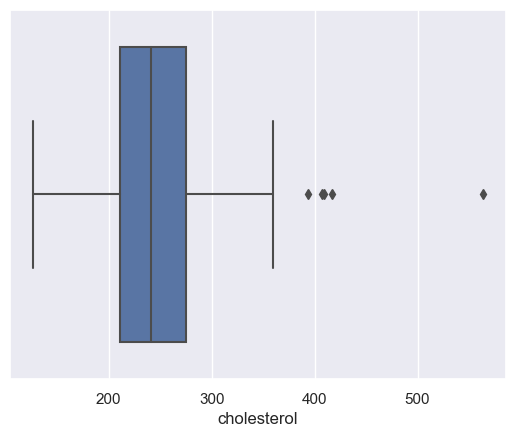

In [18]:
sns.boxplot(x=X['cholesterol'])

In [19]:
#Let's try to see if there is a corrleation between cholesterol > 350 and a target (risk of having heart attack)
indices = X[X['cholesterol']>350].index
y.loc[indices].value_counts()
#As we can see there is no correlation (and we also read that higher cholesterol not always translate to high risk of HA)
#Hence we will not delete these data points (**But maybe we shall try though?))

1    5
0    3
Name: target, dtype: int64

<AxesSubplot: xlabel='max heart rate'>

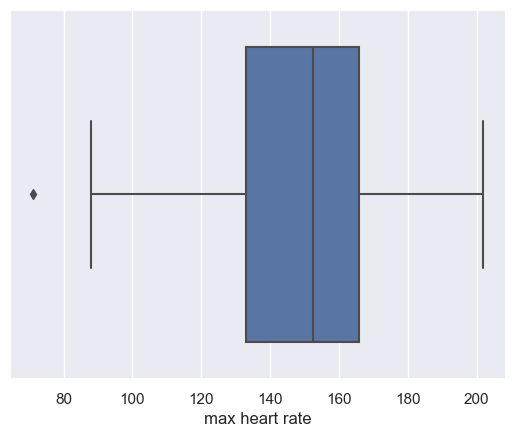

In [20]:
sns.boxplot(x=X['max heart rate'])

In [21]:
#It's strange to have max heart rate of 71, but it seems that we can leave it untouched, because intuitively lower heart rate
#means less chance of heart attack and current example is according to this intuition
rows_to_drop = X[X['max heart rate'] < 80].index
y[rows_to_drop]

271    0
Name: target, dtype: int64

<AxesSubplot: xlabel='oldpeak'>

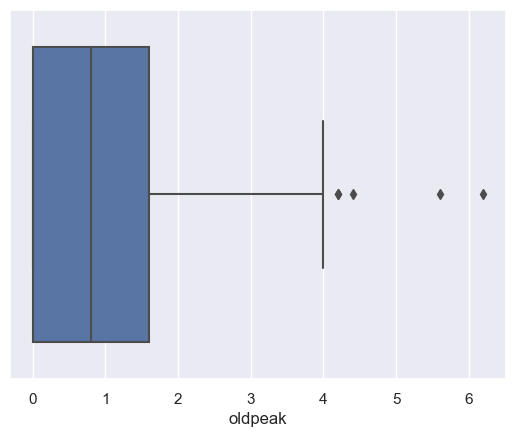

In [22]:
sns.boxplot(x=X['oldpeak'])
#We won't touch these 'outliers'

In [23]:
#train/test split (stratified) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)

#old version are not one hot encoded, for they will be fed to LightGBM, Catboost which can handle them on their own
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(X_old, y, test_size=0.15, random_state=0, stratify=y)

X_train = X_train.reset_index(drop=True)
X_train_old = X_train_old.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_train_old = y_train_old.reset_index(drop=True)

In [24]:
print(y_test.value_counts())
print(y_train.value_counts())
#We can see that class distribution is preserved 

1    24
0    21
Name: target, dtype: int64
1    137
0    116
Name: target, dtype: int64


### Feature Distributions

<AxesSubplot: xlabel='age', ylabel='Count'>

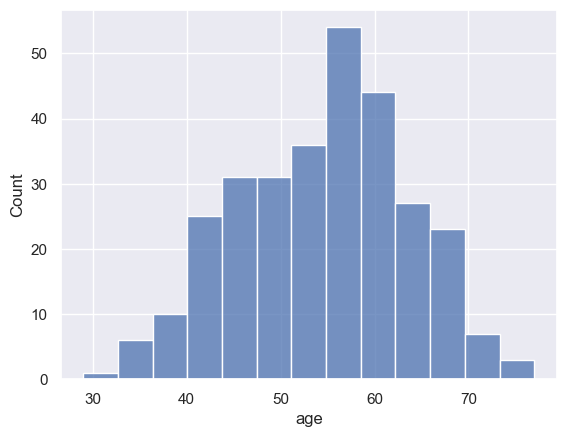

In [25]:
sns.histplot(data=X, x='age')

<AxesSubplot: xlabel='max heart rate', ylabel='Count'>

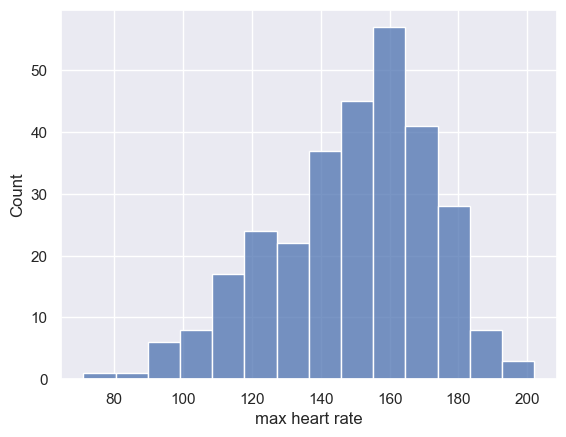

In [26]:
sns.histplot(data=X, x='max heart rate')

<AxesSubplot: xlabel='cholesterol', ylabel='Count'>

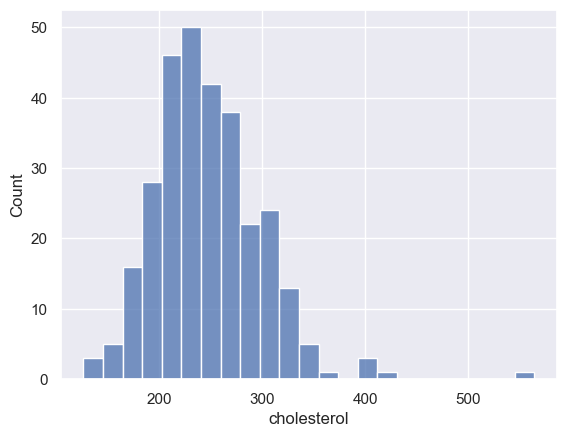

In [27]:
sns.histplot(data=X, x='cholesterol')

<AxesSubplot: xlabel='oldpeak', ylabel='Count'>

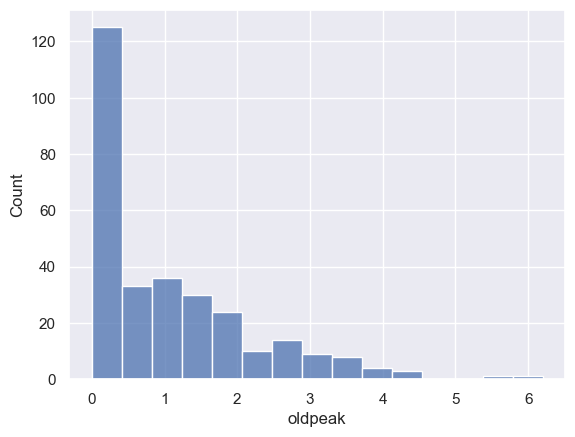

In [28]:
sns.histplot(data=X, x='oldpeak', bins=15)

# Scaling the dataset

In [29]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

min_max_scaler = MinMaxScaler()
#standard_scaler = StandardScaler()

cols_to_scale = ['age', 'resting blood pressure', 'cholesterol',
                 'max heart rate', 'oldpeak']

X_train_scale = X_train[cols_to_scale]
X_train = X_train.drop(columns=cols_to_scale)

# So that X_train and X_test will have the columns in the same order!
X_test1 = X_test.drop(columns=cols_to_scale)
X_test2 = X_test[cols_to_scale]

X_train_minmax = min_max_scaler.fit_transform(X_train_scale)
#X_train_standard = standard_scaler.fit_transform(X_train_scale)

# min_max_scaler works significantly better
X_train_minmax = pd.DataFrame(X_train_minmax, columns=cols_to_scale)
#X_train_standard = pd.DataFrame(X_train_standard, columns=cols_to_scale)

X_train = pd.concat([X_train, X_train_minmax], axis=1)
X_test = pd.concat([X_test1,X_test2], axis=1)
X_train.head()

,non-anginal pain,typical angina,atypical angina,asymptomatic,downsloping,flat,upsloping,fixed,normal,reversable defect,...,ST-T abnormality,sex,fasting bld sugar > 120,exercise induced angina,N of major vessels,age,resting blood pressure,cholesterol,max heart rate,oldpeak
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1,0,0,0,0.581395,0.448980,0.331050,0.895161,0.000000
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0,0,0,0,0.069767,0.265306,0.203196,0.798387,0.000000
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0,0,0,1,0.232558,0.244898,0.264840,0.629032,0.053571
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1,0,0,1,0.465116,1.000000,0.358447,1.000000,0.000000
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0,0,0,0,0.279070,0.112245,0.178082,0.814516,0.000000


# Helper functions

Various helper functions for different purposes that will be useful later.

In [30]:
def cross_validate_with_scores(clf, X_train, y_train, cv=5):
    """ Uses sklearn cross_validate with given parameters and outputs different useful metrics """
    
    score_dict = {}
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring='roc_auc', return_train_score=True)

    train_scores = np.round(scores['train_score'], 3)
    val_scores = np.round(scores['test_score'], 3)

    #To return dictionary containing train/validation scores
    score_dict['train_scores'] = train_scores
    score_dict['val_scores'] = val_scores
    
    #Prints train/validation scores
    train_val_scores(train_scores, val_scores)
    
    #print the mean scores for both sets
    print("\nTraining set mean auroc: {:.2f}".format(score_dict['train_scores'].mean()))
    print("Validation set mean auroc: {:.2f}".format(score_dict['val_scores'].mean()))
    
    return score_dict

In [31]:
def train_val_scores(train_scores, val_scores):
    """ Print train/validation score for each fold in cross_validate """
    
    k = 1
    for train_score, val_score in zip(train_scores, val_scores):
        print(f'Fold {k}: train = {train_score}, val = {val_score}')
        k+=1

In [32]:
def eval_metrics(y_true, y_pred):
    """ Return popular eval metrics given true labels and preds """
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    eval_metric_dict = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auroc': auc_roc
    }

    return eval_metric_dict

In [33]:
def true_false_pos_neg(y_true, y_pred):
    """ Return the number of true/false positives and true/false negatives """
    
    TP = np.sum((y_true == 1) & (y_true == y_pred))  #True Positive
    FP = np.sum((y_pred == 1) & (y_true != y_pred))  #False Positive
    TN = np.sum((y_pred == 0) & (y_true == y_pred))  #True Negative
    FN = np.sum((y_pred == 0) & (y_true != y_pred))  #False Negative
    
    pos_neg_dict = {
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN
    }
    
    return pos_neg_dict

# Models

## Logistic Regression

In [34]:
log_clf = LogisticRegression(solver='liblinear', random_state=0)
log_scores = cross_validate(log_clf, X_train, y_train, cv=5, scoring='roc_auc', return_train_score=True)

train_scores = np.round(log_scores['train_score'], 3)
val_scores = np.round(log_scores['test_score'], 3)

train_val_scores(train_scores, val_scores)

Fold 1: train = 0.958, val = 0.907
Fold 2: train = 0.952, val = 0.927
Fold 3: train = 0.942, val = 0.938
Fold 4: train = 0.944, val = 0.965
Fold 5: train = 0.951, val = 0.902


We try to find the threshold that gives the best F1-score and perform logistic regression with a given threshold.

In [35]:
log_clf.fit(X_train,y_train)

y_probas = log_clf.predict_proba(X_train)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_probas)

f1_scores = (2 * precisions * recalls) / (precisions + recalls)
        
optimal_idx = np.argmax(f1_scores)
threshold_log = thresholds[optimal_idx]
print(f'Threshold = {threshold_log:.3f} gives the best F1 score.')

Threshold = 0.365 gives the best F1 score.


We found the threshold with highest F1 and now print different evaluation metrics resulting from that threshold.

In [36]:
y_pred = (y_probas >= threshold_log).astype(int)

metric_dict = eval_metrics(y_train.values, y_pred)
for metric, value in metric_dict.items():
    print(f'{metric}: {value}')

accuracy: 0.8735177865612648
precision: 0.8343949044585988
recall: 0.9562043795620438
f1: 0.8911564625850341
auroc: 0.8660332242637806


## SVM

In [37]:
svm_clf = SVC()

svm_scores = cross_validate_with_scores(svm_clf, X_train, y_train, cv=5)

Fold 1: train = 0.974, val = 0.918
Fold 2: train = 0.972, val = 0.93
Fold 3: train = 0.97, val = 0.927
Fold 4: train = 0.965, val = 0.952
Fold 5: train = 0.975, val = 0.874

Training set mean auroc: 0.97
Validation set mean auroc: 0.92


## Decision Trees

In [39]:
tree_clf = DecisionTreeClassifier(max_depth=2)

tree_scores = cross_validate_with_scores(tree_clf, X_train, y_train, cv=5)

Fold 1: train = 0.85, val = 0.789
Fold 2: train = 0.842, val = 0.863
Fold 3: train = 0.875, val = 0.737
Fold 4: train = 0.847, val = 0.812
Fold 5: train = 0.885, val = 0.78

Training set mean auroc: 0.86
Validation set mean auroc: 0.80


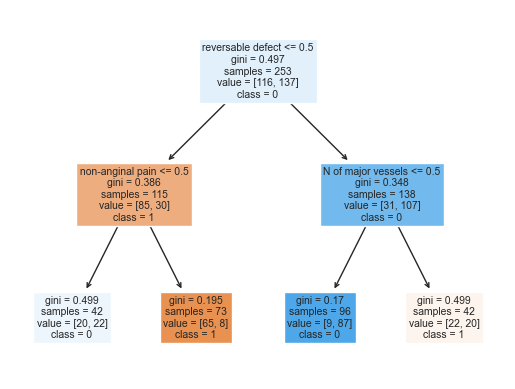

In [40]:
tree_clf.fit(X_train, y_train)

fig = plt.figure()
_ = plot_tree(tree_clf, 
                   feature_names=X_train.columns,  
                   class_names=['1','0'],
                   filled=True)

## LightGBM

In [41]:
#This is done for LightGBM
for col in X_train_old.columns:
    col_type = X_train_old[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_train_old[col] = X_train_old[col].astype('category')

In [42]:
#LightGBM cv
LGBM_clf = LGBMClassifier(random_state=0)
LGBM_scores = cross_validate_with_scores(LGBM_clf, X_train_old, y_train_old, cv=5)

Fold 1: train = 1.0, val = 0.877
Fold 2: train = 1.0, val = 0.911
Fold 3: train = 1.0, val = 0.938
Fold 4: train = 1.0, val = 0.892
Fold 5: train = 1.0, val = 0.77

Training set mean auroc: 1.00
Validation set mean auroc: 0.88


## CatBoost

In [43]:
data = train_test_split(X_train_old, y_train_old, test_size=0.15, random_state=0, stratify=y_train_old)
X_train_old_2, X_val_old, y_train_old_2, y_val_old = data

Preparing data for CatBoost Classifier.

In [44]:
from catboost import Pool

cat_indices = [0, 1, 2, 5, 6, 8, 10, 11, 12]

whole_train_pool = Pool(
    data=X_train_old, 
    label=y_train_old, 
    cat_features=cat_indices
)

train_pool = Pool(
    data=X_train_old_2, 
    label=y_train_old_2, 
    cat_features=cat_indices
)

validation_pool = Pool(
    data=X_val_old, 
    label=y_val_old, 
    cat_features=cat_indices
)

Using GridSeachCV to find the best hyperparameters for the model.

In [45]:
"""CatB_clf = CatBoostClassifier()

grid = {'learning_rate': [0.03, 0.1, 0.3],
        'depth': [4, 6],
        'l2_leaf_reg': [3, 5, 7]}

grid_search_result = CatB_clf.grid_search(grid, 
                                       X=X_train_old, 
                                       y=y_train_old,
                                       plot=True)

params = grid_search_result['params']"""

"CatB_clf = CatBoostClassifier()\n\ngrid = {'learning_rate': [0.03, 0.1, 0.3],\n        'depth': [4, 6],\n        'l2_leaf_reg': [3, 5, 7]}\n\ngrid_search_result = CatB_clf.grid_search(grid, \n                                       X=X_train_old, \n                                       y=y_train_old,\n                                       plot=True)\n\nparams = grid_search_result['params']"

In [46]:
#params

Defining CatBoost Classifier with early stopping to detect overfitting.

In [47]:
CatB_clf_early_stop = CatBoostClassifier(
    iterations=700,
    depth=4,
    l2_leaf_reg=5,
    learning_rate=0.1,
    early_stopping_rounds=50
)

CatB_clf_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

#Not tuned catboost was:
#Training set mean auroc: 0.98
#Validation set mean auroc: 0.92

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [48]:
#Number of iterations after which the validation score of the model doesn't change much, hence the model starts overfitting
best_iter = CatB_clf_early_stop.tree_count_
print(best_iter)

157


Defining CatBoost Classifier with tuned hyperparameters (via GridSearchCV) and best number of iterations (found by early stopping) to fit the model and after that we want to choose a good threshold.

In [49]:
CatB_clf = CatBoostClassifier(
    iterations=best_iter,
    depth=4,
    l2_leaf_reg=5,
    learning_rate=0.1,
)

#We fit the model to determine good threshold later
CatB_clf.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    #plot=True
)

Choosing a threshold for catboost to ensure that we get as little false negatives as possible.(Because we don't want our model to tell the patient that he doesn't have a high risk of heart attack, when in reality he does.) We would also like
to preserve our TPR. (We don't want our model to classify all of the patients as negative, giving FNR = 0, we want balance).
Looking at the FPR/FNR curve we'll determine the threshold.

In [50]:
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

curve = get_roc_curve(CatB_clf, validation_pool)
(fpr, tpr, thresholds) = curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

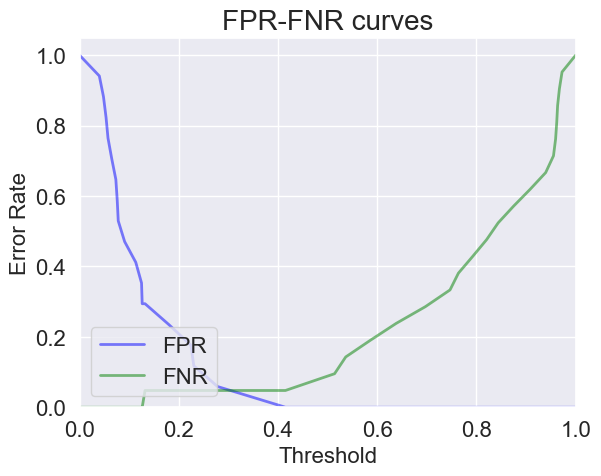

In [51]:
plt.figure()
style = {'alpha':0.5, 'lw':2}

plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
plt.plot(thresholds, fnr, color='green', label='FNR', **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True) 
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16);

In [52]:
#In the graph we can see that this is approximately the best threshold value that we can set
threshold_catb = 0.4

Final cross validation to test the models performance.

In [71]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': best_iter,
    'custom_loss': 'AUC',
    'learning_rate': 0.1,
    'depth': 4,
    'l2_leaf_reg': 5,
    'learning_rate': 0.1,
} 

#Cross validation is by default stratified
cv_data = cv(
    params=params,
    pool=whole_train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.3854687674
bestIteration = 16

Training on fold [1/5]

bestTest = 0.3988558681
bestIteration = 24

Training on fold [2/5]

bestTest = 0.314949422
bestIteration = 86

Training on fold [3/5]

bestTest = 0.3291171531
bestIteration = 97

Training on fold [4/5]

bestTest = 0.3826059505
bestIteration = 33



In [54]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.635847,0.012693,0.632116,0.010745,0.857069,0.054210
1,1,0.580345,0.015112,0.572112,0.009451,0.900497,0.034208
2,2,0.541001,0.018386,0.525061,0.014417,0.900364,0.029606
3,3,0.513484,0.021743,0.494127,0.012155,0.903954,0.025473
4,4,0.487353,0.023705,0.463105,0.013548,0.908419,0.021137


# Shap values and explanations

In [55]:
#!pip install shap

## Logistic Shaps

In [56]:
import shap

explainer = shap.Explainer(log_clf.predict, X_train)

shap_values = explainer(X_train)

Permutation explainer: 254it [00:11,  2.86it/s]                                                                        


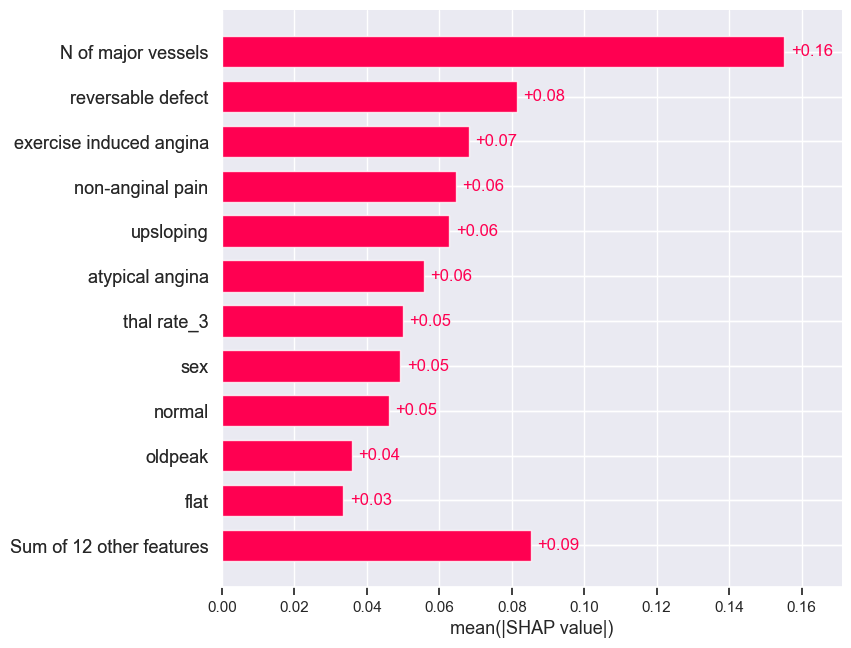

In [57]:
shap.plots.bar(shap_values.abs.mean(0), max_display=12)

We can see, that the features that had the biggest impact on the decision making process are 
* 'N of major vessels'
* Reversable defect
* exercise induced angina
* non-anginal pain
* upsloping
* atypical angina
* thal rate_3
* sex 

...

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


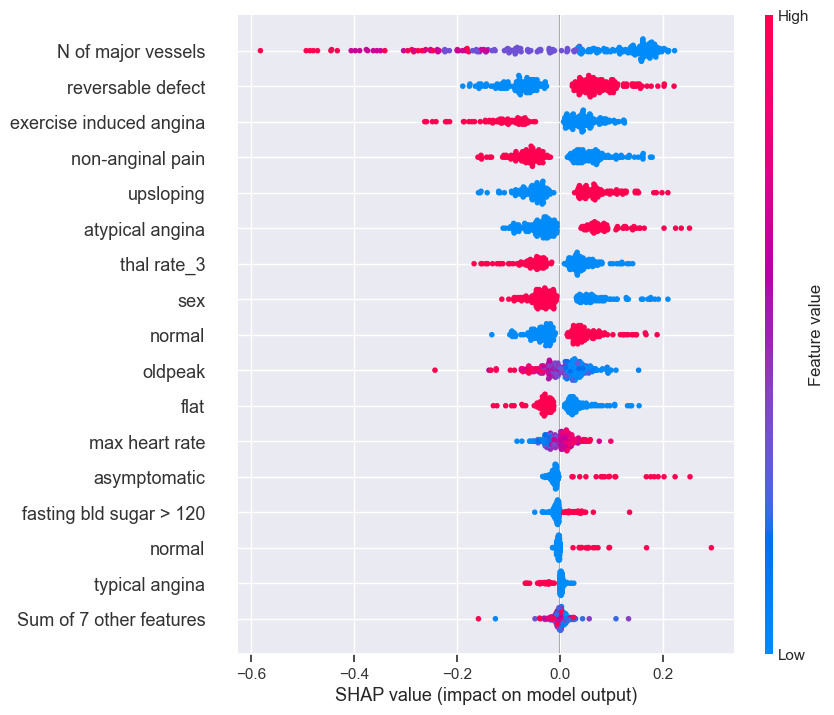

In [58]:
shap.plots.beeswarm(shap_values, max_display = 17) #, order=shap_values.abs.max(0))

We can see that 
* high number of 'N of major vessels' has resulted in the patient not having that high risk of a heart attack (negative)
* low number of 'N of major vessels' has resulted in the patient having that high risk of a heart attack (positive)
* high/low value of reversable defect hase resulted in the patient having high/low risk of heart attack (not that strong though)
* high value of exercise induced angina resulted in the patient not having that high risk of a heart attack (negative), a little less
* high value of the feature asymptomatic resulted in the patient having a risk of heart attack (positive)

... Other features have not contributed that much. (You can see the shap_plot above)

Let's view feature contributions (shap values) for a single data point

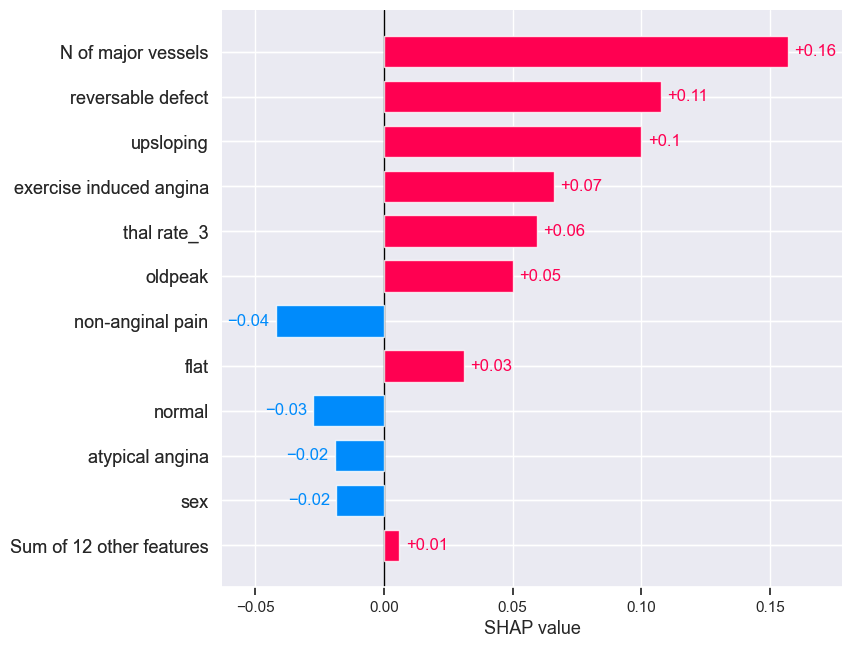

In [59]:
shap.plots.bar(shap_values[0], max_display=12)

## CatBoost Shaps

In [66]:
explainer = shap.Explainer(log_clf.predict, X_train)

shap_values = explainer(X_train)

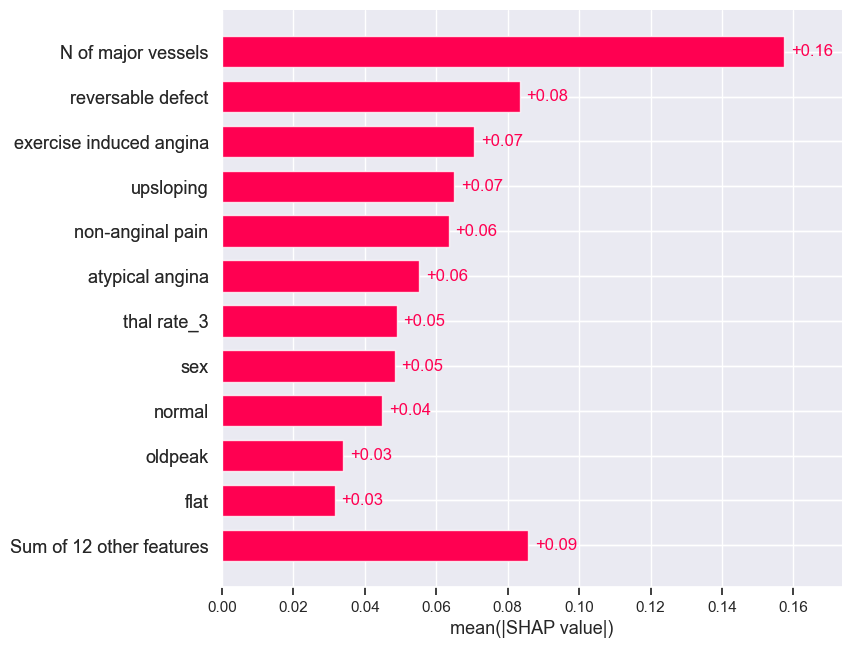

In [67]:
shap.plots.bar(shap_values.abs.mean(0), max_display=12)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


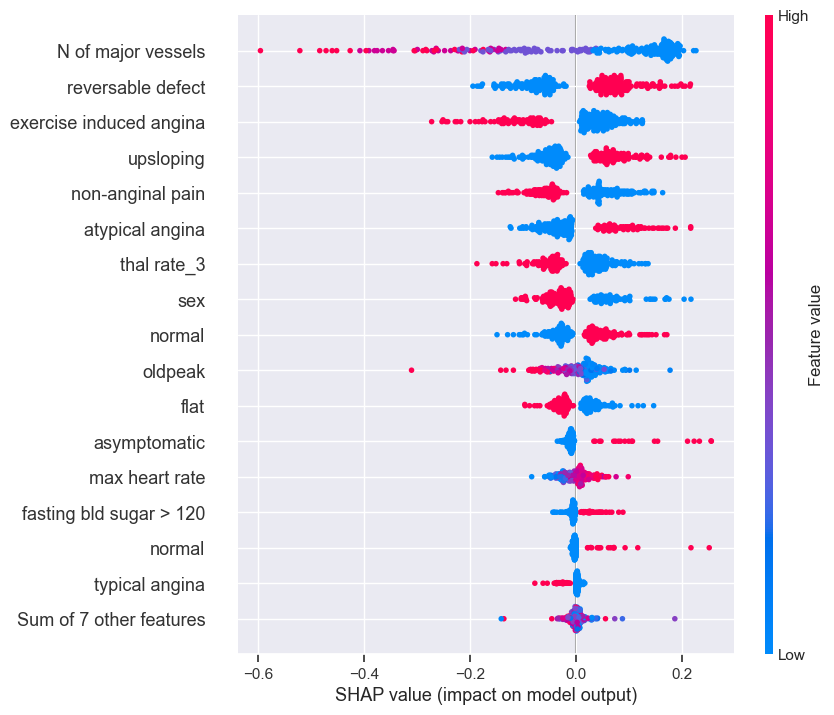

In [68]:
shap.plots.beeswarm(shap_values, max_display = 17) #, order=shap_values.abs.max(0))

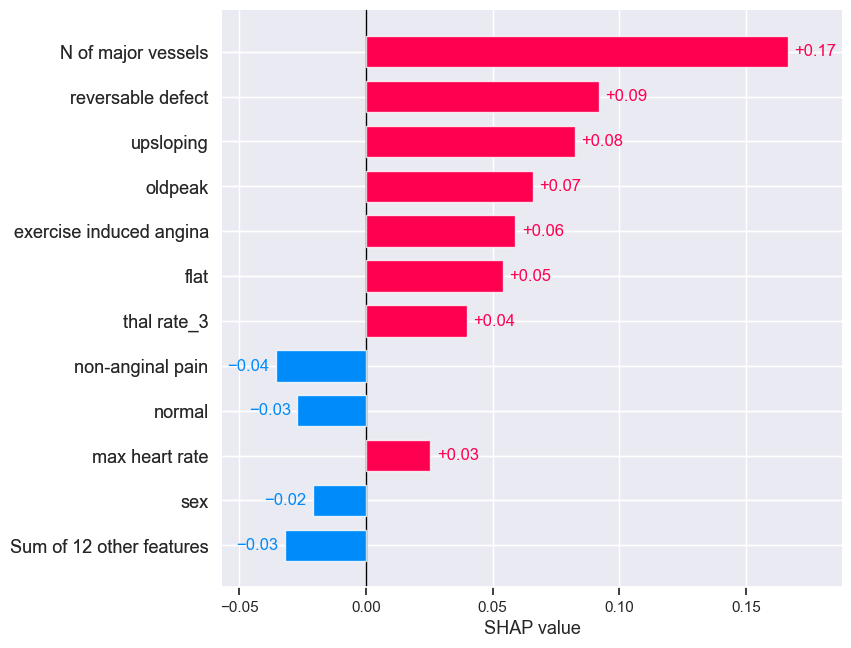

In [69]:
shap.plots.bar(shap_values[0], max_display=12)

From shap_value_plots we can see that both models simple logistic regression and catboost have very similar shap values. We can conclude that perhaps they both make predictions based on same criterias. And since they had similar validation scores. We will choose logistic regression as our final model. 

# Final Testing

In [60]:
#min-max scaling the test dataset, before giving it to our model
X_test_minmax = min_max_scaler.fit_transform(X_test)
X_test_minmax = pd.DataFrame(X_test_minmax, columns=X_test.columns)

In [61]:
y_test_probas = log_clf.predict_proba(X_test_minmax)[:, 1]
y_test_pred = (y_test_probas >= threshold_log).astype(int)

metric_dict = eval_metrics(y_test,y_test_pred)
for metric, value in metric_dict.items():
    print(f'{metric}: {value}')

pos_neg_dict = true_false_pos_neg(y_test, y_test_pred)
print(pos_neg_dict)

accuracy: 0.8444444444444444
precision: 0.8148148148148148
recall: 0.9166666666666666
f1: 0.8627450980392156
auroc: 0.8392857142857141
{'TP': 22, 'FP': 5, 'TN': 16, 'FN': 2}


In [62]:
"""y_test_probas = CatB_clf.predict_proba(X_test_old)[:, 1]

y_test_pred = (y_test_probas >= threshold_catb).astype(int)

metric_dict = eval_metrics(y_test,y_test_pred)
for metric, value in metric_dict.items():
    print(f'{metric}: {value}')

pos_neg_dict = true_false_pos_neg(y_test, y_test_pred)
print(pos_neg_dict)"""

accuracy: 0.8222222222222222
precision: 0.8076923076923077
recall: 0.875
f1: 0.8400000000000001
auroc: 0.8184523809523808
{'TP': 21, 'FP': 5, 'TN': 16, 'FN': 3}


In [63]:
#SVM
svm_clf.fit(X_train, y_train)
y_test_pred = svm_clf.predict(X_test_minmax)

pos_neg_dict = true_false_pos_neg(y_test, y_test_pred)
print(pos_neg_dict)

{'TP': 22, 'FP': 5, 'TN': 16, 'FN': 2}
